## Fairness in Classification and Representation Learning

The assignment is about building a fairness classifier for the adult dataset.
This dataset is given in three folder:

    • adult.data - training set

    • adult.test - test set
    • adult.names - information about the data
    
the preprocessing data is composed by :

    • adult train.npz - training data, 32561 examples by 113 attributes
    • adult test.npz - testing data, 16281 examples
    • adult headers.txt - a list of column names for the pre-processed dataset,
    
      indicating what each feature represents. The final entry is “income”, which
      is the label but is not in the features X. The labels , the features are
      separated array from the data x for the adult t rain and adult test.
      
So,We did some processing to build a Train data and test data with all
the features

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn           as sns

In [2]:
np.random.seed(12345)

In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 1. Preliminaries

- Loading the data

In [4]:
x = np.load('adult/adult_train/x.npy')
y = np.load('adult/adult_train/y.npy')
A = np.load('adult/adult_train/a.npy')
x_test=np.load('adult/adult_test/x.npy')
y_test=np.load('adult/adult_test/y.npy')
A_test=np.load('adult/adult_test/a.npy')
#concatenate the  data and the label
Train_data=np.hstack((x,y))
Test_data=np.hstack((x_test,y_test))
#Getting the features and get the full dataset
features =[y for y in open("adult/adult_headers.txt", "r")]
Train_data=pd.DataFrame(Train_data,columns=features)
Test_data=pd.DataFrame(Test_data,columns=features)
#Save the data to a variable that will be used if we need the original version of the dataset
adult_data=Train_data.copy()
adult_data_test=Test_data.copy()
#Datasetwith the sensible attribute A
adult_data["A"]=A

In [5]:
#Test_data

In [6]:
Train_data.head(4)

,age_u20,age_u30,age_u40,age_u50,age_u60,age_u70,age_u80,workclass_Private,workclass_Self-emp-not-inc,workclass_Self-emp-inc,...,country_Scotland,country_Thailand,country_Yugoslavia,country_El-Salvador,country_Trinadad&Tobago,country_Peru,country_Hong,country_Holand-Netherlands,country_?,income
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


- Label checking

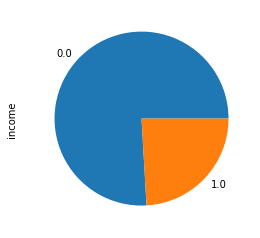

In [7]:
Train_data["income\n"].value_counts().plot.pie()
plt.savefig('label.png', dpi= 500 )
plt.show()

In [8]:
Train_data["income\n"].value_counts()

0.0    24720
1.0     7841
Name: income\n, dtype: int64

   The label of the training data is highly imbalanced

- Definition of the metrics

In [9]:
def accuracy(y, predictions):
    y=np.array(y)
    count = 0 
    for i in range(len(y)):
        if y[i]==predictions[i]:
            count += 1
    return count/len(y) 

In [10]:
#reweighted accuracy (R) of a classifier as the mean accuracy normalized by the size of the two groups
def reweighted_accuracy(A,y,predictions):
    count0 = count1= 0
    nA_one = np.count_nonzero(A)
    nA_zero = len(A)-nA_one
    for i in range(len(A)):
        if y[i]==predictions[i] and A[i]==0:
            count0 += 1
        if A[i]==predictions[i] and A[i]==1:
            count1 +=1 
            
    return 0.5*((1/nA_zero)*count0 + (1/nA_one)*count1)

In [11]:
#fairness metric ∆ DP , which measures the demographic parity (DP) :
def DP(A, predictions):
    A=np.array(A)
    count0 = count1 = 0
    nA_one = np.count_nonzero(A)
    nA_zero = len(A)-nA_one
    for i in range(len(A)):
        count0 += predictions[i] * (1- A[i])
        count1 += predictions[i] * A[i]
#     print('count 1: ', count0)
#     print('count 2: ', count1)
    
    return np.abs((count0/nA_zero) - (count1/nA_one))

### 2. Classification

### 2 - 1) Features Correlation

- Most correlated feature to income

Using Pearson correlation to determine the 10 most correlated future with label Y and the sensible attribute A

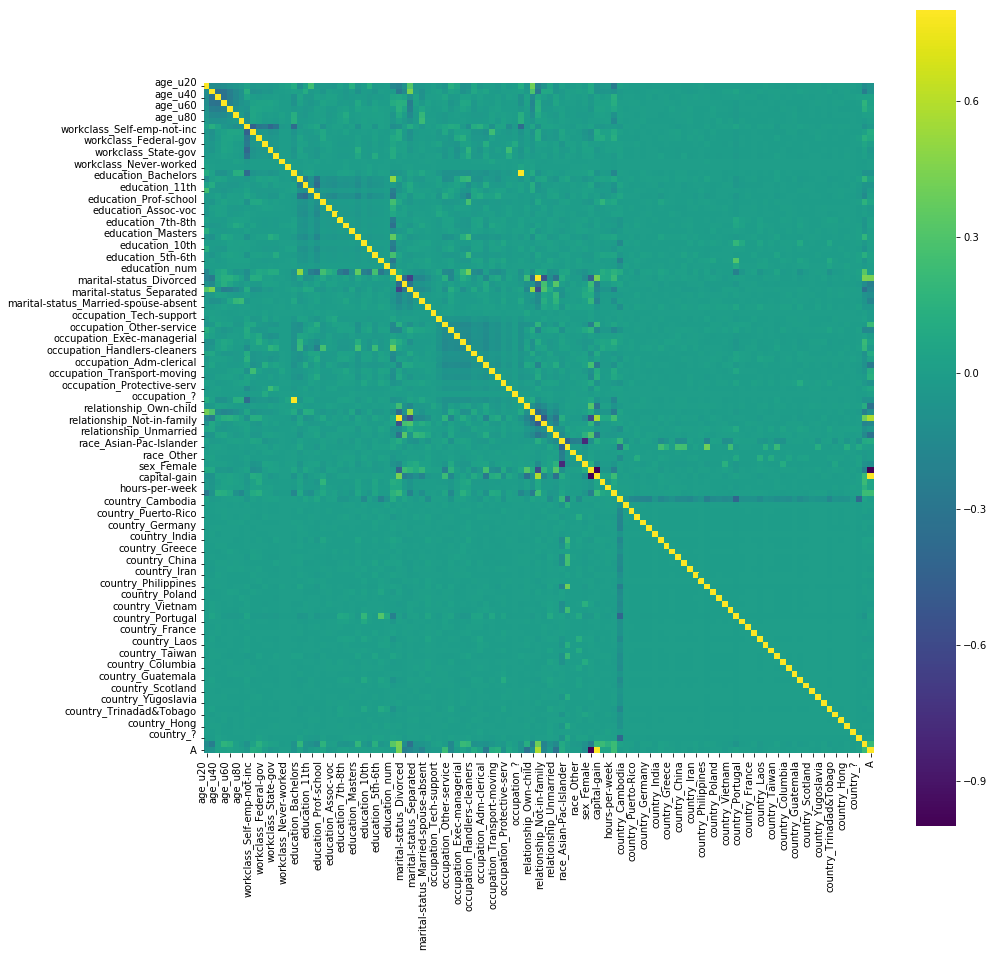

In [12]:
corrmat=adult_data.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corrmat,vmax=.8, square=True,cmap='viridis',linecolor="white");
plt.savefig('correlation.png', dpi= 500 )

In [13]:
corr_val=pd.DataFrame(np.abs(corrmat['income\n']))
corr=corr_val.sort_values(by='income\n',ascending=False) # We have the correlation in descending order and the first row is the variable y itself
ten_most=corr[1:11]
print("\n The 10 most correlated features with Y are:")
ten_most


 The 10 most correlated features with Y are:


,income
marital-status_Married-civ-spouse\n,0.444696
relationship_Husband\n,0.401035
education_num\n,0.335154
marital-status_Never-married\n,0.318440
age_u30\n,0.238133
hours-per-week\n,0.229689
relationship_Own-child\n,0.228532
capital-gain\n,0.223329
sex_Male\n,0.215980
sex_Female\n,0.215980


- Most correlated feature to the sensitive attribute A= "sex_Male"

In [15]:
corr_valA=pd.DataFrame(np.abs(corrmat['A']))
corrA=corr_valA.sort_values(by='A',ascending=False) # We have the correlation in descending order and the first row is the variable y itself
ten_mostA=corrA[1:11]
print("\n The 10 most correlated features with sencible attribute A are:")
ten_mostA


 The 10 most correlated features with sencible attribute A are:


,A
sex_Female\n,1.000000
sex_Male\n,1.000000
relationship_Husband\n,0.580135
marital-status_Married-civ-spouse\n,0.431805
relationship_Unmarried\n,0.321273
relationship_Wife\n,0.319311
occupation_Adm-clerical\n,0.263148
hours-per-week\n,0.229309
marital-status_Divorced\n,0.228621
occupation_Craft-repair\n,0.223128


###  2 - 2 ) Binary Classifier for Prediction

In [17]:
from sklearn.model_selection import train_test_split
from sklearn                 import metrics
from sklearn.metrics         import confusion_matrix

In [18]:
#Remove the label of the data
Train_data.drop(['income\n'], axis = 1, inplace = True, errors = 'ignore')
Test_data.drop(['income\n'], axis = 1, inplace = True, errors = 'ignore')
Train_data.to_csv("training_data.csv",index=False)
Test_data.to_csv("test_data.csv",index=False)
#Splitting the data into train and validation set
x_train,x_val,y_train,y_val=train_test_split(Train_data,y, test_size = 0.2)

In [19]:
# from sklearn.ensemble import RandomForestClassifier
# cf=RandomForestClassifier()
# cf=cf.fit(x_train,y_train)
# y_hat=cf.predict(Test_data)
# accuracy(y_test, y_hat)

- Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
clf_LR=LogisticRegression()
clf_LR=clf_LR.fit(x_train,y_train)
print("\n Training score: ",clf_LR.score(x_train, y_train)) #evaluating the training error
predictions = clf_LR.predict(x_val)
score =  accuracy(y_val, predictions)#metrics.accuracy_score(pred, y_val)
print("\nThe  accuracy in the validation set is: ",score)


 Training score:  0.8542306511056511

The  accuracy in the validation set is:  0.8542914171656687


#### test model

In [21]:
y_hat=clf_LR.predict(Test_data)
sc=  accuracy(y_test, y_hat) #metrics.accuracy_score(pred,y_val)
print("\nThe accuracy score that we get is: ",sc)


The accuracy score that we get is:  0.856704133652724


 #### Computing of the demographic parity DP

In [22]:
dp= DP(A_test,y_hat)
print("\nThe demographic parity that we get is: ",dp)


The demographic parity that we get is:  [0.17768128]


In [23]:
print(metrics.classification_report(y_test,y_hat))

             precision    recall  f1-score   support

        0.0       0.89      0.93      0.91     12435
        1.0       0.74      0.61      0.67      3846

avg / total       0.85      0.86      0.85     16281



- Remove the 10 most correlated features to A and Retrain

In [24]:
def removeCorr_top10_feature(data):

    toRemove=["sex_Female\n","sex_Male\n","relationship_Husband\n","marital-status_Married-civ-spouse\n","relationship_Unmarried\n","relationship_Wife\n","occupation_Adm-clerical\n","hours-per-week\n","marital-status_Divorced\n","occupation_Craft-repair\n"]

    for r in toRemove:
        data.drop([r], axis = 1, inplace = True, errors = 'ignore')
    return data
data=removeCorr_top10_feature(Train_data)
data.head(5)

,age_u20,age_u30,age_u40,age_u50,age_u60,age_u70,age_u80,workclass_Private,workclass_Self-emp-not-inc,workclass_Self-emp-inc,...,country_Nicaragua,country_Scotland,country_Thailand,country_Yugoslavia,country_El-Salvador,country_Trinadad&Tobago,country_Peru,country_Hong,country_Holand-Netherlands,country_?
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
x_train,x_val,y_train,y_val=train_test_split(data,y, test_size = 0.2)

In [26]:
#x_train

In [27]:
print("\t %%% Now lets fit our model first and then we test with our validation set %%%")
clf_LR = clf_LR.fit(x_train,y_train)
print("\n Training score: ",clf_LR.score(x_train, y_train)) #evaluating the training error
pred = clf_LR.predict(x_val)
score = accuracy(y_val, pred)
print("\nThe validation score that we get is: ",score)

	 %%% Now lets fit our model first and then we test with our validation set %%%

 Training score:  0.8446713759213759

The validation score that we get is:  0.8403193612774451


#### test model

In [28]:
new_data_test=removeCorr_top10_feature(Test_data)
y_hat=clf_LR.predict(new_data_test)
sc= accuracy(y_test, y_hat)#metrics.accuracy_score(pred, y_val)
print("\nThe accuracy score that we get is: ",sc)


The accuracy score that we get is:  0.8479208893802592


In [29]:
print(metrics.classification_report(y_test, y_hat))

             precision    recall  f1-score   support

        0.0       0.87      0.94      0.90     12435
        1.0       0.74      0.55      0.63      3846

avg / total       0.84      0.85      0.84     16281



In [30]:
dp=DP(A_test,y_hat)
print("\nThe demographic parity that we get is: ",dp)


The demographic parity that we get is:  [0.1357734]


### 2 - 3 ) Correlation with the prediction 

#### Three most correlated to Y_hat

In [31]:
# Adding the sensible attribute and the prediction to the test data
data_with_pred=Test_data.copy()
data_with_pred["A"]=A_test
data_with_pred["Y_hat"]=y_hat
#Getting the 3 mosr correlated 
corrmat_pred= data_with_pred.corr()
corr_val=pd.DataFrame(np.abs(corrmat_pred['Y_hat']))
corr=corr_val.sort_values(by='Y_hat',ascending=False) # We have the correlation in descending order and the first row is the variable y itself
three_most=corr[1:4]
print("\n The 3 most correlated features with Y_hat are:")
three_most


 The 3 most correlated features with Y_hat are:


,Y_hat
education_num\n,0.471660
education_Bachelors\n,0.313140
marital-status_Never-married\n,0.300396


#### Three most correlated to Y_hat when A=0

In [33]:
data_with_pred["A"]= A_test
sub_test=data_with_pred.loc[data_with_pred["A"]==0]
corrmat_pred= sub_test.corr()
corr_val=pd.DataFrame(np.abs(corrmat_pred['Y_hat']))
corr=corr_val.sort_values(by='Y_hat',ascending=False) # We have the correlation in descending order and the first row is the variable y itself
three_most=corr[1:4]
print("\n The 3 most correlated features with Y_hat when A=0 are:")
three_most


 The 3 most correlated features with Y_hat when A=0 are:


,Y_hat
education_num\n,0.327592
capital-gain\n,0.308933
education_Masters\n,0.259705


#### Three most correlated to Y_hat when A=1

In [35]:
sub_test1=data_with_pred.loc[data_with_pred["A"]==1]
corrmat_pred= sub_test1.corr()
corr_val=pd.DataFrame(np.abs(corrmat_pred['Y_hat']))
corr=corr_val.sort_values(by='Y_hat',ascending=False) # We have the correlation in descending order and the first row is the variable y itself
three_most=corr[1:4]
print("\n The 3 most correlated features with Y_hat when A=1 are:")
three_most


 The 3 most correlated features with Y_hat when A=1 are:


,Y_hat
education_num\n,0.527556
education_Bachelors\n,0.359940
occupation_Exec-managerial\n,0.314171


### 2 - 4) Classifier to predict A

- Make a version of the dataset for the prediction of A by removing sex_Male and sex_Female

In [37]:
#adult_data

In [38]:
#Getting the base training set and remove  sex_Male and sex_Female feature
data=adult_data.copy()
data.drop(['sex_Male'], axis = 1, inplace = True, errors = 'ignore')
data.drop(['sex_Female'], axis = 1, inplace = True, errors = 'ignore')
data.drop(['income\n'], axis = 1, inplace = True, errors = 'ignore')

In [39]:
data.drop(['A'], axis = 1, inplace = True, errors = 'ignore')

In [40]:
#Getting the base test set and remove  sex_Male and sex_Female feature
Test_data=adult_data_test.copy()
Test_data.drop(['income\n'], axis = 1, inplace = True, errors = 'ignore')
Test_data.drop(['sex_Male'], axis = 1, inplace = True, errors = 'ignore')
Test_data.drop(['sex_Female'], axis = 1, inplace = True, errors = 'ignore')
Test_data.drop(['A'], axis = 1, inplace = True, errors = 'ignore')

In [41]:
#Test_data

- Prediction of A

In [42]:
#Splitting the data into train and validation set
x_train_A,x_val_A,A_train,A_val=train_test_split(data,A, test_size = 0.2)
clf_LR =clf_LR.fit(x_train_A,A_train)
pred_A=clf_LR.predict(x_val_A)
score = accuracy(A_val, pred_A)
print("\nThe validation score that we get is: ",score)


The validation score that we get is:  1.0


- Test new version of data

In [43]:
pred_test=clf_LR.predict(Test_data)
test_score = accuracy(A_test, pred_test)
print("\nThe test accuracy that we get is: ",test_score)
acc_reweight = reweighted_accuracy(A_test,A_test,pred_test)
print("\nThe reweighted_accuracy that we get is: ",acc_reweight)


The test accuracy that we get is:  1.0

The reweighted_accuracy that we get is:  1.0


- Remove the feature correlated to A and retrain

In [44]:
Train_without_corr=removeCorr_top10_feature(Train_data)
Train_without_corr.drop(['A'], axis = 1, inplace = True, errors = 'ignore')
#Splitting the data into train and validation set
x_train_A,x_val_A,A_train,A_val=train_test_split(Train_without_corr,A, test_size = 0.3)
clf_LR =clf_LR.fit(x_train_A,A_train)
pred_A=clf_LR.predict(x_val_A)
score = accuracy(A_val, pred_A)
print("\nThe validation score that we get is: ",score)


The validation score that we get is:  0.714812160917187


In [45]:
#x_train

- Test new version of data

In [46]:
Test_without_corr=removeCorr_top10_feature(Test_data)
pred_test_A=clf_LR.predict(Test_without_corr)
test_score= accuracy(A_test,pred_test_A)
print("\nThe accuracy in the test set that we get is: ",test_score)
acc_reweight=reweighted_accuracy(A_test,A_test,pred_test_A)
print("\nThe reweighted_accuracy in the test set score that we get is: ",acc_reweight)


The accuracy in the test set that we get is:  0.7111356796265585

The reweighted_accuracy in the test set score that we get is:  0.6338510661933692


### 3) Representation Learning

### 3 - 1) Preprocessing of features and classification

- Fit  Gaussian to each feature for group A=0 and 1 for preprocessing of features

In [47]:
def preprocessing_data(df):
    for r in features:
        m0=df[r][df["A"]==0].mean()
        sig0=df[r][df["A"]==0].std()
        m1=df[r][df["A"]==1].mean()
        sig1=df[r][df["A"]==1].std()
        if sig0 <1e-4:
            sig0=1
        if sig1<1e-4 :
            sig1=1
        df[r][df["A"]==0]=(df[r][df["A"]==0] -m0)/sig0
        df[r][df["A"]==1]=(df[r][df["A"]==1] -m1)/sig1
    return df    

In [48]:
df=adult_data.copy()
Train_preprocess=preprocessing_data(df)
Train_preprocess.head()

,age_u20,age_u30,age_u40,age_u50,age_u60,age_u70,age_u80,workclass_Private,workclass_Self-emp-not-inc,workclass_Self-emp-inc,...,country_Thailand,country_Yugoslavia,country_El-Salvador,country_Trinadad&Tobago,country_Peru,country_Hong,country_Holand-Netherlands,country_?,income,A
0,3.506621,-0.646631,-0.560633,-0.500963,-0.358539,-0.245431,-0.140663,0.624029,-0.196126,-0.112657,...,-0.031972,-0.016691,-0.057094,-0.031972,-0.036074,-0.023607,-0.009635,-0.123953,-0.350576,0.0
1,-0.285148,1.546335,-0.560633,-0.500963,-0.358539,-0.245431,-0.140663,0.624029,-0.196126,-0.112657,...,-0.031972,-0.016691,-0.057094,-0.031972,-0.036074,-0.023607,-0.009635,-0.123953,-0.350576,0.0
2,-0.201100,-0.537048,-0.619040,-0.546686,2.414190,-0.262327,-0.140189,-1.477424,-0.330172,-0.217120,...,-0.017926,-0.024432,-0.057174,-0.019164,-0.027942,-0.025355,0.000000,-0.140189,1.506879,1.0
3,-0.201100,-0.537048,-0.619040,1.829119,-0.414199,-0.262327,-0.140189,-1.477424,-0.330172,-0.217120,...,-0.017926,-0.024432,-0.057174,-0.019164,-0.027942,-0.025355,0.000000,-0.140189,1.506879,1.0
4,-0.285148,-0.646631,-0.560633,-0.500963,-0.358539,4.074081,-0.140663,0.624029,-0.196126,-0.112657,...,-0.031972,-0.016691,-0.057094,-0.031972,-0.036074,-0.023607,-0.009635,-0.123953,-0.350576,0.0


- Classifiers to predict Y(income) and A

 Predictions of the income Y

In [49]:
#Train_data = df.copy()
Train_preprocess.drop(['income\n'], axis = 1, inplace = True, errors = 'ignore')
Train_preprocess.drop(['A'], axis = 1, inplace = True, errors = 'ignore')
x_train,x_val,y_train,y_val=train_test_split(Train_preprocess,y, test_size = 0.2)

In [50]:
import torch
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from mmd import MMD_torch

Using TensorFlow backend.


In [51]:
def Classifier_NN(train_data, train_target, val_data, val_target,batch_size=32, epochs=30, verbose=1):
    # Build neural network
    model = Sequential()
    # as first layer in a sequential model:
    model.add(Dense(256, activation='relu', input_dim=train_data.shape[1]))
    #model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

    # Train model
    model.fit(train_data, train_target,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose,
              validation_data=(val_data, val_target))
    return model

In [52]:
g=Classifier_NN(x_train, y_train, x_val, y_val,batch_size=32, epochs=30, verbose=1)

Train on 26048 samples, validate on 6513 samples
Epoch 1/30
26048/26048 [==============================] - 1s 44us/step - loss: 0.3552 - acc: 0.8391 - val_loss: 0.3461 - val_acc: 0.8399
Epoch 2/30
26048/26048 [==============================] - 1s 46us/step - loss: 0.3167 - acc: 0.8545 - val_loss: 0.3331 - val_acc: 0.8445
Epoch 3/30
26048/26048 [==============================] - 1s 42us/step - loss: 0.3064 - acc: 0.8579 - val_loss: 0.3306 - val_acc: 0.8480
Epoch 4/30
26048/26048 [==============================] - 1s 44us/step - loss: 0.3002 - acc: 0.8626 - val_loss: 0.3286 - val_acc: 0.8481
Epoch 5/30
26048/26048 [==============================] - 1s 51us/step - loss: 0.2934 - acc: 0.8647 - val_loss: 0.3331 - val_acc: 0.8454
Epoch 6/30
26048/26048 [==============================] - 1s 53us/step - loss: 0.2876 - acc: 0.8678 - val_loss: 0.3369 - val_acc: 0.8462
Epoch 7/30
26048/26048 [==============================] - 2s 61us/step - loss: 0.2828 - acc: 0.8698 - val_loss: 0.3413 - val_acc:

- Test predictions

In [53]:
Test_df=adult_data_test.copy()
Test_df["A"]=A_test
Test_preprocess=preprocessing_data(Test_df)
Test_preprocess.drop(['income\n'], axis = 1, inplace = True, errors = 'ignore')
Test_preprocess.drop(['A'], axis = 1, inplace = True, errors = 'ignore')

In [54]:
y_hat=g.predict(Test_preprocess)
test_scores=g.evaluate(Test_preprocess,y_test)
print("\n%s: %.2f%%" % (g.metrics_names[1], test_scores[1]*100))
dp=DP(A_test,y_hat)
print("\nThe demographic parity that we get is: ",dp)

16281/16281 [==============================] - 0s 15us/step

acc: 82.92%

The demographic parity that we get is:  [0.18785192]


- Predictions of A

In [55]:
x_train_A,x_val_A,A_train,A_val=train_test_split(Train_preprocess,A,test_size = 0.2)

In [56]:
h=Classifier_NN(x_train_A, A_train, x_val_A, y_val,batch_size=32, epochs=30, verbose=1)

Train on 26048 samples, validate on 6513 samples
Epoch 1/30
26048/26048 [==============================] - 1s 42us/step - loss: 0.1372 - acc: 0.9481 - val_loss: 5.0584 - val_acc: 0.4103
Epoch 2/30
26048/26048 [==============================] - 1s 39us/step - loss: 0.0140 - acc: 0.9976 - val_loss: 6.2376 - val_acc: 0.4109
Epoch 3/30
26048/26048 [==============================] - 1s 39us/step - loss: 0.0111 - acc: 0.9983 - val_loss: 6.1272 - val_acc: 0.4130
Epoch 4/30
26048/26048 [==============================] - 1s 40us/step - loss: 0.0061 - acc: 0.9985 - val_loss: 7.2527 - val_acc: 0.4121
Epoch 5/30
26048/26048 [==============================] - 1s 40us/step - loss: 0.0059 - acc: 0.9990 - val_loss: 7.4539 - val_acc: 0.4116
Epoch 6/30
26048/26048 [==============================] - 1s 39us/step - loss: 0.0033 - acc: 0.9995 - val_loss: 8.0545 - val_acc: 0.4112
Epoch 7/30
26048/26048 [==============================] - 1s 39us/step - loss: 0.0049 - acc: 0.9996 - val_loss: 8.3555 - val_acc:

- Test

In [57]:
A_hat=h.predict(Test_preprocess)
test_scores=h.evaluate(Test_preprocess,A_test)
print("\n%s: %.2f%%" % (h.metrics_names[1], test_scores[1]*100))
acc_reweighted=reweighted_accuracy(A_test,A_test,A_hat)
print("\nThe reweighted_accuracy for the classifier of A is: ",acc_reweighted)

16281/16281 [==============================] - 0s 14us/step

acc: 99.93%

The reweighted_accuracy for the classifier of A is:  0.47937384898710866


#### 3 - 2 ) MMD

In [58]:
#Sample a part of the dataset , convert it to tensor and compute the MMD
batch_data= np.array(adult_data)[0:8000,:]
batch_data=torch.tensor(batch_data)
A_tensor=torch.tensor(A[0:8000,:])
mmd_value =MMD_torch(batch_data,A_tensor)

In [59]:
#Define the regularizer
def reguralizer(alpha):
    return alpha * mmd_value.item()

In [60]:
#%%writefile Classifier_MMD.py
def Classifier_with_regularizer(train_data, train_target, val_data, val_target,regularizer, batch_size=32, epochs=50, verbose=1):
    # Build neural network
    model = Sequential()
    # as first layer in a sequential model:
    model.add(Dense(256, activation='relu', input_dim=train_data.shape[1]))
    #model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizer))
    #model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

    # Train model
    model.fit(train_data, train_target,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose,
              validation_data=(val_data, val_target))
    return model

- Prediction of Y

In [61]:
alpha=0.01
g=Classifier_with_regularizer(x_train,y_train,x_val, y_val,reguralizer, batch_size=32, epochs=50, verbose=1)

Train on 26048 samples, validate on 6513 samples
Epoch 1/50
26048/26048 [==============================] - 2s 59us/step - loss: 0.3562 - acc: 0.8393 - val_loss: 0.3397 - val_acc: 0.8437
Epoch 2/50
26048/26048 [==============================] - 1s 55us/step - loss: 0.3184 - acc: 0.8535 - val_loss: 0.3330 - val_acc: 0.8466
Epoch 3/50
26048/26048 [==============================] - 2s 62us/step - loss: 0.3065 - acc: 0.8600 - val_loss: 0.3371 - val_acc: 0.8480
Epoch 4/50
26048/26048 [==============================] - 1s 53us/step - loss: 0.2994 - acc: 0.8628 - val_loss: 0.3377 - val_acc: 0.8474
Epoch 5/50
26048/26048 [==============================] - 2s 62us/step - loss: 0.2946 - acc: 0.8646 - val_loss: 0.3318 - val_acc: 0.8439
Epoch 6/50
26048/26048 [==============================] - 1s 44us/step - loss: 0.2870 - acc: 0.8679 - val_loss: 0.3340 - val_acc: 0.8457
Epoch 7/50
26048/26048 [==============================] - 1s 42us/step - loss: 0.2819 - acc: 0.8695 - val_loss: 0.3378 - val_acc:

 Test classifier of Y

In [62]:
test_scores=g.evaluate(Test_preprocess,y_test)
print("\n%s: %.2f%%" % (g.metrics_names[1], test_scores[1]*100))

16281/16281 [==============================] - 0s 19us/step

acc: 82.65%


- Prediction of A

 Training and evaluation

In [63]:
h=Classifier_with_regularizer(x_train_A,A_train,x_val_A,A_val,reguralizer, batch_size=32, epochs=50, verbose=1)

Train on 26048 samples, validate on 6513 samples
Epoch 1/50
26048/26048 [==============================] - 1s 47us/step - loss: 0.1324 - acc: 0.9501 - val_loss: 0.0312 - val_acc: 0.9932
Epoch 2/50
26048/26048 [==============================] - 2s 62us/step - loss: 0.0164 - acc: 0.9973 - val_loss: 0.0167 - val_acc: 0.9971
Epoch 3/50
26048/26048 [==============================] - 1s 50us/step - loss: 0.0099 - acc: 0.9981 - val_loss: 0.0048 - val_acc: 0.9980
Epoch 4/50
26048/26048 [==============================] - 1s 57us/step - loss: 0.0051 - acc: 0.9990 - val_loss: 0.0171 - val_acc: 0.9979
Epoch 5/50
26048/26048 [==============================] - 1s 50us/step - loss: 0.0076 - acc: 0.9987 - val_loss: 0.0196 - val_acc: 0.9977
Epoch 6/50
26048/26048 [==============================] - 1s 49us/step - loss: 0.0057 - acc: 0.9994 - val_loss: 0.0079 - val_acc: 0.9986
Epoch 7/50
26048/26048 [==============================] - 1s 52us/step - loss: 0.0043 - acc: 0.9994 - val_loss: 0.0069 - val_acc:

 Test the classifier that the prdictions A

In [64]:
#Classifier_with_regularizer(x_train_A,A_train,Test_preprocess,A_test,reguralizer, batch_size=32, epochs=50, verbose=1)
test_scoresA=h.evaluate(Test_preprocess,A_test)
print("\n%s: %.2f%%" % (g.metrics_names[1], test_scoresA[1]*100))


16281/16281 [==============================] - 0s 18us/step

acc: 99.93%


- Performance for range values of the hyperparameter alpha

In [65]:
# y_hat_list = y_hat_mmd.tolist()
# for i in range(len(y_hat_mmd)):
#     y_hat_list[i] = y_hat_list[i][0]
# y_test_list = []
# for i in range(len(y_test)):
#     y_test_list.append(y_test[i][0])

In [66]:
# y_test.flatten()

In [67]:
alpha = [1, 0.1, 0.01, 0.001, 0.0001]
accuracy = []
delta_DP = []
accuracy_A = []
reweighted_acc = []
for a in alpha:
    print('model for alpha == ', a)
    def l1_reg(a):
         return a * mmd_value.item()
    print("====\t %%% Now lets fit the classifier G , that predict Y %%%=====")
    # Build neural network
    classifierG = Classifier_with_regularizer(x_train, y_train, x_val, y_val, l1_reg, batch_size=16, epochs= 30, verbose=0)
    score = classifierG.evaluate(Test_preprocess,y_test.flatten())
    accuracy.append(score[1])
    print('Test accuracy for Y:', score[1])
    y_hat_mmd = classifierG.predict(Test_preprocess)
    delta_DP.append(DP(A_test,y_hat_mmd))
    print('deltaDP for Y', DP(A_test,y_hat_mmd))
    print('=='*30)
    
    print("====\t %%% Now lets fit the classifier H , that predict A %%%=====")
    classifierH = Classifier_with_regularizer(x_train_A, A_train, x_val_A, A_val, l1_reg, batch_size=16, epochs= 30, verbose=0)
    scoreA = classifierH.evaluate(Test_preprocess,A_test)
    accuracy_A.append(scoreA[1])
    print('Test accuracy for A:', scoreA[1])
    A_hat_mmd = classifierH.predict(Test_preprocess)
    reweighted_acc.append(reweighted_accuracy(A_test, A_test,A_hat_mmd))
    print('reweighted accuracy for A', reweighted_accuracy(A_test, A_test,A_hat_mmd))
    print('=='*30)

model for alpha ==  1
====	 %%% Now lets fit the classifier G , that predict Y %%%=====
16281/16281 [==============================] - 0s 22us/step
Test accuracy for Y: 0.8345310484284477
deltaDP for Y [0.17589769]
====	 %%% Now lets fit the classifier H , that predict A %%%=====
16281/16281 [==============================] - 0s 30us/step
Test accuracy for A: 0.9988329955162459
reweighted accuracy for A 0.4942449355432781
model for alpha ==  0.1
====	 %%% Now lets fit the classifier G , that predict Y %%%=====
16281/16281 [==============================] - 0s 23us/step
Test accuracy for Y: 0.8382163258041417
deltaDP for Y [0.18238724]
====	 %%% Now lets fit the classifier H , that predict A %%%=====
16281/16281 [==============================] - 0s 20us/step
Test accuracy for A: 0.9972360420121614
reweighted accuracy for A 0.47191528545119704
model for alpha ==  0.01
====	 %%% Now lets fit the classifier G , that predict Y %%%=====
16281/16281 [==============================] - 0s 20us

- Plot the values of accuracy and Delta_DP for prediction of Y

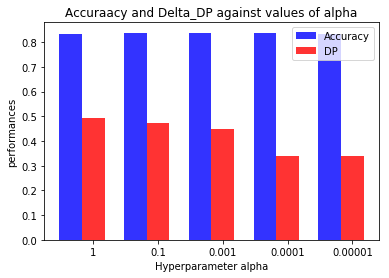

In [68]:
n_hyperparameters=5
#Plotting
fix,ax=plt.subplots()
index=np.arange(n_hyperparameters)
bar_width=0.35
opacity=0.8

rect1=plt.bar(index,accuracy,bar_width,alpha=opacity,color='blue',label="Accuracy")
rect2=plt.bar(index+bar_width,reweighted_acc,bar_width,alpha=opacity,color='red',label="DP")
plt.xlabel("Hyperparameter alpha")
plt.ylabel("performances")
plt.title("Accuraacy and Delta_DP against values of alpha")
plt.xticks(index+bar_width,("1","0.1","0.01","0.001","0.0001"))
plt.legend()
plt.savefig('Accuracy&Delta_DP_alpha_range_good.png', dpi=500)
plt.show()

- Plot accury and weighted accuracy for prediction of A

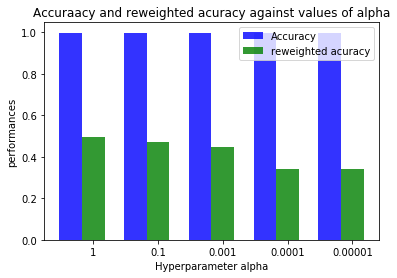

In [69]:
n_hyperparameters=5
#Plotting
fix,ax=plt.subplots()
index=np.arange(n_hyperparameters)
bar_width=0.35
opacity=0.8

rect1=plt.bar(index,accuracy_A,bar_width,alpha=opacity,color='blue',label="Accuracy")
rect2=plt.bar(index+bar_width,reweighted_acc,bar_width,alpha=opacity,color='green',label="reweighted acuracy")
plt.xlabel("Hyperparameter alpha")
plt.ylabel("performances")
plt.title("Accuraacy and reweighted acuracy against values of alpha")
plt.xticks(index+bar_width,("1","0.1","0.001","0.0001","0.00001"))
plt.legend()
plt.savefig('Accuracy&weighted_acc_alpha_range_good.png', dpi=500)
plt.show()